In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import hdbscan
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [64]:
def get_x_Y(df, target_col, periods_ahead):
    
    # and clean it up
    df.index = pd.to_datetime(df.date)
    df = df.drop('date', 1)
    df = df[df.index >= datetime(2017, 3, 2)]
    df = df[[col for col in df.columns.tolist() if '_pat_' not in col]]
    print('\nShape:', df.shape,'\n')
    
    # select target column and create it in dataset
    target_col_name = 'target'
    df[target_col_name] = df[target_col].shift(-periods_ahead)
    df[target_col_name] = (df[target_col_name] - df[target_col]) / df[target_col]
    
    # and drop the NaN values
    df = df.dropna()
    
    # set X and y
    X = df.iloc[:,:-1].as_matrix().copy()
    y = df.iloc[:,-1].as_matrix().copy()
    
    return X, y, df

# get X, Y, and column headers / names for random forest
def get_lstm_matrix(df, target_col, periods_ahead, drop_target = False, rate_of_change = False):
    
    # read in all cols with closing prices
    df = df[df[target_col].notnull()]
    
    # clean data for BTC_ETH starts on 2015-08-09
    df = df[df.index >= datetime(2015, 8, 9)]
    
    # select target column and create it in dataset
    target_col_name = target_col + '_target'
    df[target_col_name] = df[target_col].shift(-periods_ahead)
    
    # if looking at the rate of change instead of actual values
    if rate_of_change:
        df[target_col_name] = (df[target_col_name] - df[target_col]) / df[target_col]
    
    # drop the original target col
    if drop_target:
        df = df.drop(target_col, 1)
    
    # drop null values
    df.dropna(inplace = True)
    
    # convert to matrix
    dat = df.as_matrix()
    
    # convert to float (just in case)
    dat = dat.astype('float32')
    
    # get dates for QA
    dates = df.index.tolist()
    
    return df, dat, dates

# reshape data so that LSTM doesn't get mad
def reshape_data(array, time_steps):
    
    # set length / number of samples
    L = array.shape[0] - time_steps + 1
    
    # use strides for something
    strided = np.lib.stride_tricks.as_strided
    m, n = array.strides
    
    # set width / number of features
    N = array.shape[1]
    
    # and finally, reshape data according to specifications
    reshaped = strided(array, shape = (L, time_steps, N), strides = (N * n, m, n))
    
    return reshaped.copy()

# helper to get a specific number of features
def set_features(df, target_col, n_features):
    
    # get list of features and slice the n we need, then add back target
    features_list = [col for col in df.columns if col != target_col][:n_features]
    features_list.append(target_col)
    
    return features_list

# get lagged version of X (straight up, no RoC)
def get_lagged_x_straight(_array, timesteps):
    
    # reshpae to add timesteps
    reshaped_array = reshape_data(_array, timesteps)
    
    # flatten to two dimensions
    flattened_array = np.array([list(sub_arr.reshape(1,-1)[0]) for sub_arr in reshaped_array])
    
    return flattened_array

# get lagged version of X, w/ rate of change for each timestep
def get_lagged_x_roc(_array, timesteps):
    
    # reshpae to add timesteps
    reshaped_array = reshape_data(_array, timesteps)

    reshaped_roc_array = []

    for arr in reshaped_array:

        # init indices
        i_first = 0
        i_second = 1

        # create a new sub matrix for appending
        new_arr = [arr[0,:]]

        # loop through each timestep
        for i in range(timesteps - 1):

            # get the recent|current and the previous record for calc RoC
            recent_record = arr[i_first,:]
            prev_record = arr[i_second,:]

            # calculate the rate of change between the recent and previous
            new_arr.append((recent_record - prev_record) / prev_record)

            i_first += 1
            i_second += 1

        # append the new sub matrix to the full new matrix
        reshaped_roc_array.append(np.array(new_arr))

    # flatten to two dimensions
    flattened_array = np.array([list(sub_arr.reshape(1,-1)[0]) for sub_arr in np.array(reshaped_roc_array)])
    
    return flattened_array

# get a lagged version of the dataset for a specific n of timesteps
def get_lagged_dataset(df, target_col, periods_ahead, n_features, timesteps, roc, binary_target = True):
    
    # filter dowm to n features needed
    df = df[set_features(df, target_col, n_features)]
    
    # pre-process data
    adf, dat, dates = get_lstm_matrix(df,
                                      target_col = target_col,
                                      periods_ahead = periods_ahead,
                                      drop_target = True,
                                      rate_of_change = True
                                     )
    
    if binary_target:
        
        # add the target col
        adf['direction'] = adf[target_col + '_target'].apply(lambda x: np.sign(x))

        # reverse order of df so it is more intuitive
        adf = adf.sort_index(ascending = False)

        # set X and y
        X = adf.iloc[:,:-2].as_matrix().copy()
        y = adf.iloc[:,-1].as_matrix().copy()
    
    else:
        
        # reverse order of df so it is more intuitive
        adf = adf.sort_index(ascending = False)

        # set X and y
        X = adf.iloc[:,:-1].as_matrix().copy()
        y = adf.iloc[:,-1].as_matrix().copy()
    
    if roc:
        # transform X to add n lag
        X = get_lagged_x_roc(X, timesteps).copy()
    elif not roc:
        # transform X to add n lag
        X = get_lagged_x_straight(X, timesteps).copy()
        
    else: 'Please choose lag type!'
    
    # trim y to match X
    y = y[:-timesteps+1].copy()
    
    # create a df of the lagged data for easy exploration
    lag_df = pd.DataFrame(X)
    lag_df['target'] = y
    
    return X, y, lag_df

# Data Sample

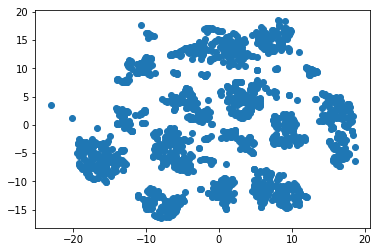

In [6]:
digits = datasets.load_digits()
data = digits.data
tsne = TSNE()
projection = tsne.fit_transform(data)
plt.scatter(*projection.T);

# Load Data

In [59]:
# read in data
df = pd.read_csv('_trainingData/train_filtered_6hr_2017-09-27.csv')

X, y, df = get_x_Y(df = df,
                   target_col = 'polo_usdteth_median_trade_price',
                   periods_ahead = 4
                  )

# scale X
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)


Shape: (837, 86) 



In [60]:
# init HDBSCAN
model = hdbscan.HDBSCAN()

# fit the data
model.fit(X)

# add the HDBSCAN labels to the df
df['oob_labels'] = model.labels_

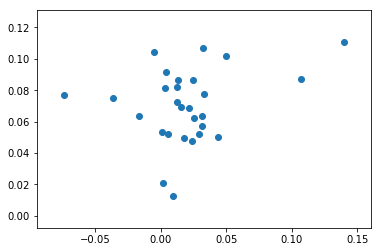

In [61]:
# plot the mean / std of the target for each cluster
plt.scatter(df.groupby('oob_labels').mean().target.values, df.groupby('oob_labels').std().target.values);

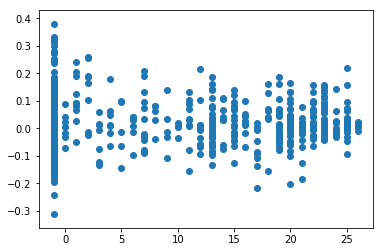

In [63]:
plt.scatter(x = model.labels_, y = y)

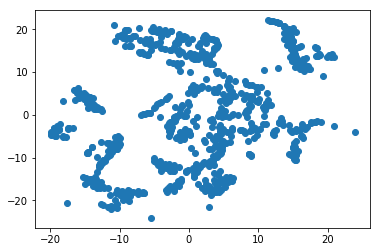

In [62]:
tsne = TSNE()
projection = tsne.fit_transform(X)
plt.scatter(*projection.T);

In [12]:
proj_df = pd.DataFrame(projection)

In [14]:
proj_df['oob_labels'] = model.labels_

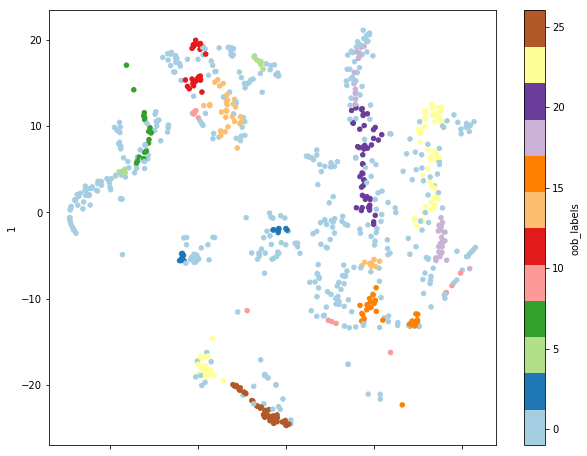

In [26]:
proj_df.plot(x = 0, y = 1, c = 'oob_labels', kind = 'scatter', colormap = 'Paired', figsize = (10,8))

# HDBSCAN w/ Lagged Dataset

In [65]:
# read in training data
df = pd.read_csv('_trainingData/train_filtered_6hr_2017-09-27.csv')

# clean import
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)

In [71]:
###
# SET DATA PARAMS

_target = 'polo_usdteth_median_trade_price'
n_timesteps = 24
features = (df.shape[1] - 1)

cv_folds = 5

########################

X, y, lag_df = get_lagged_dataset(df,
                                  target_col = _target,
                                  periods_ahead = 4,
                                  n_features = features,
                                  timesteps = n_timesteps,
                                  roc = False,
                                  binary_target = False
                                 )

In [73]:
# init HDBSCAN
model = hdbscan.HDBSCAN()

# fit the data
model.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [74]:
lag_df['hdbscan_cluster'] = model.labels_

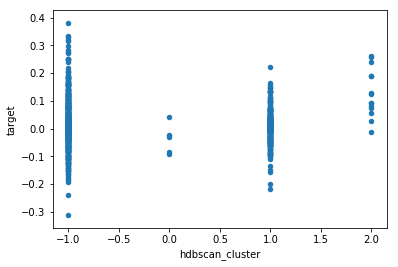

In [75]:
lag_df.plot(x = 'hdbscan_cluster', y = 'target', kind = 'scatter');

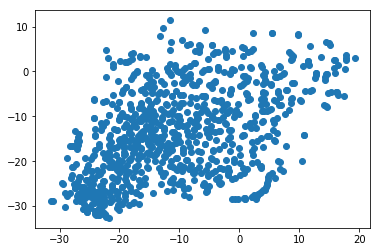

In [58]:
tsne = TSNE()
projection = tsne.fit_transform(X)
plt.scatter(*projection.T);